#Tratando os Dados

In [1]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
from sklearn.metrics import precision_recall_fscore_support as score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
sms = pd.read_csv('train_data.csv')
validacao = pd.read_csv('validation_data.csv')

In [3]:
sms.head(5)

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked


In [4]:
sms.query('LABEL != "blocked"')

,SMS,LABEL
1500,recuperamos seu usuario e senha de acesso no i...,ok
1501,recuperamos seu usuario e senha de acesso no i...,ok
1502,"MARSH CORRETORA: Felipe, boleto parc. 01 do Se...",ok
1503,"MARSH CORRETORA: Felipe, boleto parc. 01 do Se...",ok
1504,"MARSH CORRETORA: Anna, boleto parc. 01 do Seg ...",ok
...,...,...
5995,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok
5996,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5997,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5998,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok


In [5]:
sms.shape

(6000, 2)

In [6]:
validacao.head()

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...


In [7]:
validacao.shape

(2000, 1)

In [8]:
sms.groupby('LABEL').describe()

SMS                                                               
        count unique                                                top freq
LABEL                                                                       
blocked  1500   1495  Mercado BTC - Ha uma nova mensagem pendente. h...    3
ok       4500   4364                      131.221.110.19 DNS-SECUNDARIO   13

# Pre-Processando as Mensagens

In [9]:
def text_preprocess(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = [word for word in text.split() if word.lower() not in stopwords.words('portuguese')]
  return " ".join(text)

In [10]:
sms_copy = sms.SMS.copy()
sms_copy.head()

0    BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...
1    050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...
2      060804CB5F0303|ps: //bancodobrasil.seguranca.gq
3    Atualizacao ainda nao foi executado em sua con...
4      0608042BE40303|ps://bancodobrasil.seguranca.cf/
Name: SMS, dtype: object

In [13]:
sms_copy = sms_copy.apply(text_preprocess)
sms_copy.head() 

0    BOLETO REFERENTE PARCELAS ATRASO CONSÓRCIO BBC...
1           050003DA0202lcloudapplelnccomiphoneVtBqROY
2            060804CB5F0303ps bancodobrasilsegurancagq
3    Atualizacao ainda nao executado conta Evite bl...
4             0608042BE40303psbancodobrasilsegurancacf
Name: SMS, dtype: object

In [14]:
vetorizar = TfidfVectorizer('portuguese')

In [15]:
sms_matriz = vetorizar.fit_transform(sms_copy)
sms_matriz

<6000x11636 sparse matrix of type '<class 'numpy.float64'>'
	with 58709 stored elements in Compressed Sparse Row format>

In [16]:
matriz_de_validacao = vetorizar.transform(validacao.SMS)
matriz_de_validacao

<2000x11636 sparse matrix of type '<class 'numpy.float64'>'
	with 15465 stored elements in Compressed Sparse Row format>

#Aplicando o Modelo

In [17]:
sms_train,sms_test,spam_naospam_train,spam_naospam_test = train_test_split(sms_matriz,sms.LABEL,test_size=0.3,random_state=20)

In [18]:
sms_test.shape

(1800, 11636)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

modelo = LogisticRegression(solver='liblinear',penalty='l1')
modelo.fit(sms_train,spam_naospam_train)
predicao = modelo.predict(sms_test)

print('A acurária do modelo foi de: {}'.format(accuracy_score(spam_naospam_test,predicao).round(4)))

A acurária do modelo foi de: 0.9828


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
predicao

array(['ok', 'ok', 'ok', ..., 'ok', 'blocked', 'ok'], dtype=object)

#Validação

In [21]:
predicao_validacao = modelo.predict(matriz_de_validacao)
predicao_validacao

array(['blocked', 'blocked', 'blocked', ..., 'ok', 'ok', 'ok'],
      dtype=object)

In [22]:
validacao['LABEL'] = predicao_validacao

In [23]:
validacao.head()

,SMS,LABEL
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked


In [24]:
validacao.groupby('LABEL').describe()

SMS                                                               
        count unique                                                top freq
LABEL                                                                       
blocked   449    448  Seu aparelho perdido foi localizado e esta onl...    2
ok       1551   1481  Zabbix PE-BARAO-01:: BGP Session from LYRA NET...    7

In [55]:
from google.colab import files
validacao.to_csv('validation_data.csv') 
files.download('validation_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Classificação do Modelo

##Dummy Classifier

In [26]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(sms_train, spam_naospam_train)
acuracia = dummy_stratified.score(sms_test, spam_naospam_test) * 100

print("A acurácia do dummy stratified foi de %.2f%%" % acuracia)

A acurácia do dummy stratified foi de 61.56%


##Matriz de Confusão

In [27]:
spam_naospam_test.shape

(1800,)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(spam_naospam_test,predicao)

array([[ 446,   28],
       [   3, 1323]])

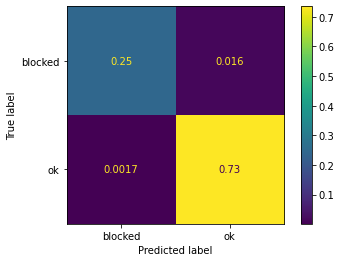

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(spam_naospam_test,predicao,labels=modelo.classes_,normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot()

##K-Fold

In [47]:
from sklearn.model_selection import cross_val_score

kfolds = 5
scores = cross_val_score(modelo, sms_matriz,sms.LABEL, cv = kfolds, scoring = "accuracy") 
print("Resultado dos k testes", scores)
print("Média dos testes", scores.mean())
print("Desvio Padrão dos testes", scores.std())

Resultado dos k testes [0.88083333 0.8225     0.9925     1.         1.        ]
Média dos testes 0.9391666666666666
Desvio Padrão dos testes 0.07383728356626106
